Problem Statement 1: Trade Logic & Risk Control Basics

1. What does leverage less than 1 mean? Does it normally make financial sense? Think of its utility/applicability in our backtesting engine, if any. (Hint: Think of position sizing)

Asnwer: Leverage less than 1 means using less than the total capital available for a trade. Yes, it does make financial sense as it can be useful in managing risk in volatile or uncertain markets. In backtesting engine, leverage<1 can be used to test conservative strategies or to implement some kind of risk-adjusted position-sizing techniques.

2. Explain the difference between a static stop loss and a trailing stop loss in the context of trade risk management. Discuss how each behaves in a trending market versus a volatile market.
   
Answer: Static stop loss remains fixed once we set it to a certain value whereas trailing stop loss moves up if price increases but doesn't move when price falls.
In trending market, the prices do not fluctuate much and therefore chances of stop loss getting trigerred is low.So, trailing stoploss would be more profitable in this case whereas static stop loss may exit the trade early, missing out on trend continuation.
In volatile markets, those fluctuations are enough to pull the stop loss and this makes trailing stop losses triggered much sooner as their value keeps going up and the markets are very unsettled, so that we book a loss and the prices will rise in some time. Therefore, static loss would be preferred in this case.

3. Analyze whether implementing a trailing take profit is necessary. Is its behavior captured by some other already defined risk management method? If yes, then name it.

Answer: Trailing-Take-Profit (TTP) is a condition that monitors the price trend and automatically closes your position once a certain profit is achieved, while also defining the maximum acceptable loss. Although it can be useful but it is not necessary. 
Its behaviour is captured by Trailing Stop Loss.

4. In what scenarios can a trade remain open even after the price falls below the set stop-loss level?

Answer: A trade can remain open even after the price falls below the set stop-loss level in the following scenarios:
i>>Let’s say someone buys a stock at 100 and set a stop-loss at 95.
You use a stop-limit order with a limit price of 94.50.
If the stock suddenly gaps down to 94 due to unexpected news, your stop is triggered at 95, but the limit order to sell at 94.50 won’t execute since the price has already fallen below it.

ii>>If someone simulates trades using daily candles, and stop-loss is at 95.
The candle for a day shows: Open = 100, Low = 94, Close = 96.
If the backtest only checks the close, it might miss that the price actually hit the stop-loss.
Result: The trade falsely appears to remain valid.

iii>> Sometimes, broker API delays may also cause this.



Problem Statement 2: Probabilistic Pattern Validator

Overview
The objective of this problem statement is to test whether common candlestick patterns truly improve the odds of a profitable trade. You will analyze three patterns—Doji, Hammer, and Engulfing—and compare their empirical win-rates against a baseline random entry strategy.

Task Description
1. Pattern Identification:
For each of the specified candlestick patterns, scan a given OHLCV dataset and locate all occurrences of the pattern. Use data from any NSE-listed stock of your choice, covering a period of the last 5 years.

In [3]:
!pip install yfinance plotly mplfinance --quiet

import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics

In [5]:
# Set some display options
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

In [9]:
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])

    return data

stock_symbol = 'RELIANCE.NS'
data = download_flat_yf(stock_symbol, start='2020-06-01', end='2025-06-01', interval='1wk')
data.head()

,datetime,close,high,low,open,volume
0,2020-06-01,725.019287,741.658470,676.545644,678.402088,154757986
1,2020-06-08,728.273804,741.841850,686.194503,741.841850,138339465
2,2020-06-15,806.473389,819.949713,715.576656,717.364353,292352189
3,2020-06-22,798.337097,827.008758,784.608644,812.890683,220348291
4,2020-06-29,819.537170,821.874956,777.205802,792.103179,142586268


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  261 non-null    datetime64[ns]
 1   close     261 non-null    float64       
 2   high      261 non-null    float64       
 3   low       261 non-null    float64       
 4   open      261 non-null    float64       
 5   volume    261 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 12.4 KB


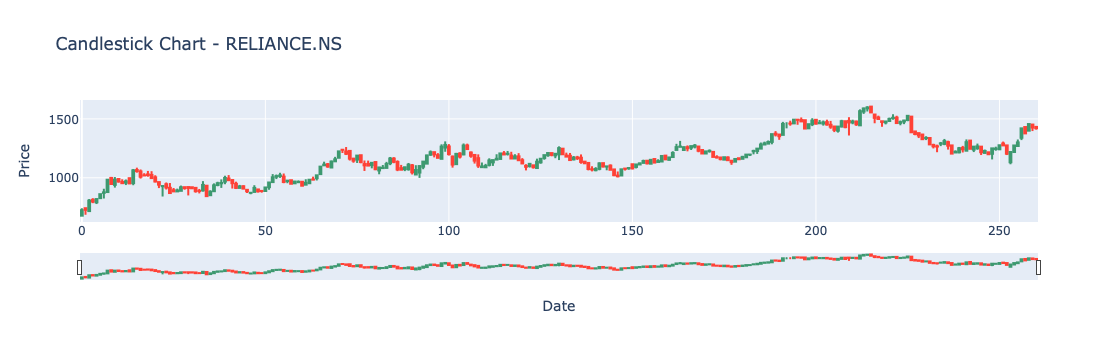

In [13]:
fig = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'])
              ])
fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig.show()

In [15]:
def is_bullish_engulfing(data, i):
    prev = data.iloc[i - 1]
    curr = data.iloc[i]
    return (
        prev['close'] < prev['open'] and
        curr['close'] > curr['open'] and
        curr['open'] < prev['close'] and
        curr['close'] > prev['open']
    )

In [17]:
def is_bearish_engulfing(data, i):
    prev = data.iloc[i - 1]
    curr = data.iloc[i]
    return (
        prev['close'] > prev['open'] and
        curr['close'] < curr['open'] and
        curr['open'] > prev['close'] and
        curr['close'] < prev['open']
    )

In [19]:
def is_doji(data, i):
    body = abs(data.iloc[i]['open'] - data.iloc[i]['close'])
    range_ = data.iloc[i]['high'] - data.iloc[i]['low'] + 1e-9
    return body / range_ < 0.1

In [21]:
def is_hammer(data, i):
    row = data.iloc[i]
    body = abs(row['close'] - row['open'])
    lower_shadow = min(row['open'], row['close']) - row['low']
    upper_shadow = row['high'] - max(row['open'], row['close'])

    return lower_shadow > 2 * body and upper_shadow < body

In [23]:
def generate_candlestick_signals(data):
    data['bullish_engulfing_signal'] = 0
    data['bearish_engulfing_signal'] = 0
    data['simple_candlestick_signal'] = 0
    data['signals'] = 0

    for i in range(1, len(data)):
        if is_bullish_engulfing(data, i):
            data.loc[i, 'bullish_engulfing_signal'] = 1
        if is_bearish_engulfing(data, i):
            data.loc[i, 'bearish_engulfing_signal'] = -1
        if is_doji(data, i):
            data.loc[i, 'simple_candlestick_signal'] = 1
        if is_hammer(data, i):
            data.loc[i, 'hammer_signal'] = 1

    # Candlestick-based entries
    data.loc[data['bullish_engulfing_signal'] == 1, 'signals'] = 1
    data.loc[data['bearish_engulfing_signal'] == -1, 'signals'] = -1

    # Doji + RSI-based reversal signals
    if 'RSI' in data.columns:
        data.loc[(data['simple_candlestick_signal'] == 1) & (data['RSI'] < 40), 'signals'] = 1
        data.loc[(data['simple_candlestick_signal'] == 1) & (data['RSI'] > 60), 'signals'] = -1

    print("Buy signals:", (data['signals'] == 1).sum())
    print("Sell signals:", (data['signals'] == -1).sum())
    print("Total non-zero signals:", (data['signals'] != 0).sum())

    return data

Buy signals: 11
Sell signals: 15
Total non-zero signals: 26


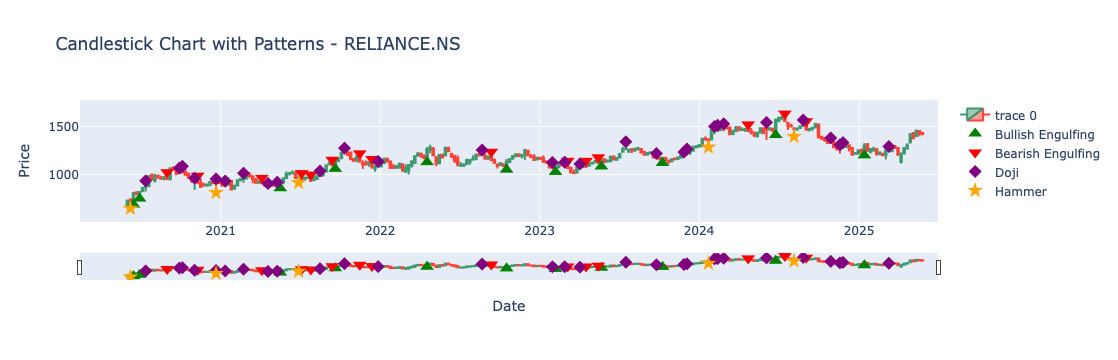

In [29]:
#@title Visualisation
def plot_candlestick_patterns(data, patterns_to_mark=[]):
    fig = go.Figure(data=[
        go.Candlestick(x=data['datetime'],
                       open=data['open'],
                       high=data['high'],
                       low=data['low'],
                       close=data['close'])
    ])

    if 'bullish_engulfing' in patterns_to_mark:
        buy_signals_candle = data[data['bullish_engulfing_signal'] == 1]
        fig.add_trace(go.Scatter(
            x=buy_signals_candle['datetime'],
            y=buy_signals_candle['low'] - (data['high'] - data['low']).mean() * 0.5, # Position below the low
            mode='markers',
            marker=dict(color='green', size=12, symbol='triangle-up'),
            name='Bullish Engulfing'
        ))

    if 'bearish_engulfing' in patterns_to_mark:
        sell_signals_candle = data[data['bearish_engulfing_signal'] == -1]
        fig.add_trace(go.Scatter(
            x=sell_signals_candle['datetime'],
            y=sell_signals_candle['high'] + (data['high'] - data['low']).mean() * 0.5, # Position above the high
            mode='markers',
            marker=dict(color='red', size=12, symbol='triangle-down'),
            name='Bearish Engulfing'
        ))

    if 'doji' in patterns_to_mark:
        doji_signals_candle = data[data['simple_candlestick_signal'] == 1]
        fig.add_trace(go.Scatter(
            x=doji_signals_candle['datetime'],
            y=doji_signals_candle['high'] + (data['high'] - data['low']).mean() * 0.5, # Position above the high
            mode='markers',
            marker=dict(color='purple', size=10, symbol='diamond'),
            name='Doji'
        ))
    if 'hammer' in patterns_to_mark:
        hammer_signals_candle = data[data['hammer_signal'] == 1]
        fig.add_trace(go.Scatter(
            x=hammer_signals_candle['datetime'],
            y=hammer_signals_candle['low'] - (data['high'] - data['low']).mean() * 0.7,
            mode='markers',
            marker=dict(color='orange', size=12, symbol='star'),
            name='Hammer'
        ))


    fig.update_layout(title=f"Candlestick Chart with Patterns - {stock_symbol}",
                      xaxis_title='Date',
                      yaxis_title='Price')
    fig.show()

# Generate candlestick signals
data_with_patterns = generate_candlestick_signals(data.copy()) # Use a copy to avoid modifying the original 'data' DataFrame

# Plot the candlestick chart and mark the patterns
plot_candlestick_patterns(data_with_patterns, patterns_to_mark=['bullish_engulfing', 'bearish_engulfing', 'doji','hammer'])

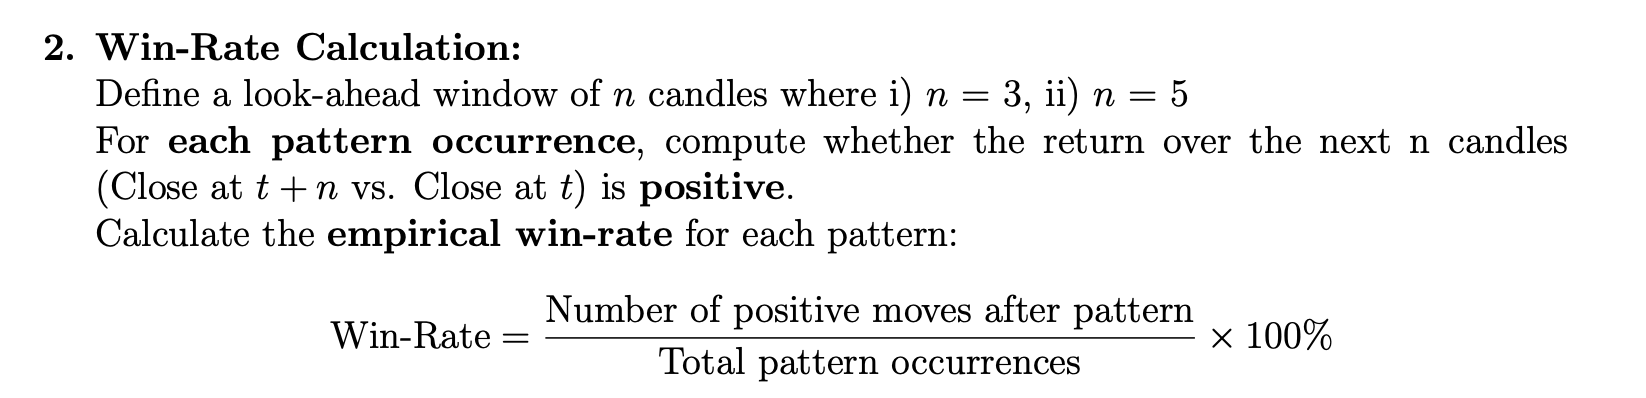

In [42]:
def compute_win_rate(data, signal_col, n):
    pattern_indices = data.index[data[signal_col] == 1].tolist()
    wins = 0
    valid_signals = 0

    for i in pattern_indices:
        if i + n < len(data):
            ret = data.loc[i + n, 'close'] - data.loc[i, 'close']
            valid_signals += 1
            if ret > 0:
                wins += 1

    if valid_signals == 0:
        return 0, 0
    return (wins / valid_signals) * 100, valid_signals

3. Baseline Win-Rate:
Simulate random entries: Select M timestamps uniformly at random (excluding the last
n candles) and compute the empirical win-rate over the same n-candle horizon.
M= Z Number of occurrences of pattern i

In [44]:
def simulate_random_baseline(data, n, m, seed=19):
    np.random.seed(seed)
    max_idx = len(data) - n
    random_indices = np.random.choice(max_idx, size=m, replace=False)
    
    wins = 0
    for i in random_indices:
        ret = data.loc[i + n, 'close'] - data.loc[i, 'close']
        if ret > 0:
            wins += 1
    return (wins / m) * 100

4. Visualization:
Plot a ’beautiful’ grouped bar chart: one bar for the baseline win-rate, and one bar for
each of the three patterns.
The x-axis should list: Baseline, Doji, Hammer, Engulfing.
The y-axis should represent win-rate percentage.

In [46]:
def gather_all_win_rates(data, n):
    win_rates = {}
    doji_rate, doji_count = compute_win_rate(data, 'simple_candlestick_signal', n)
    hammer_rate, hammer_count = compute_win_rate(data, 'hammer_signal', n)
    engulfing_rate, engulfing_count = compute_win_rate(data, 'bullish_engulfing_signal', n)

    # Baseline count is average of pattern counts
    total_count = (doji_count + hammer_count + engulfing_count) // 3
    baseline_rate = simulate_random_baseline(data, n, total_count)

    win_rates['Baseline'] = baseline_rate
    win_rates['Doji'] = doji_rate
    win_rates['Hammer'] = hammer_rate
    win_rates['Engulfing'] = engulfing_rate
    return win_rates


In [48]:
import plotly.express as px

def plot_grouped_bar(win_rates_n3, win_rates_n5):
    patterns = list(win_rates_n3.keys())
    values_n3 = list(win_rates_n3.values())
    values_n5 = list(win_rates_n5.values())

    df_plot = pd.DataFrame({
        'Pattern': patterns * 2,
        'Win Rate (%)': values_n3 + values_n5,
        'Window': ['n=3'] * len(patterns) + ['n=5'] * len(patterns)
    })

    fig = px.bar(df_plot, x='Pattern', y='Win Rate (%)', color='Window',
                 barmode='group', text_auto='.2f',
                 title='Pattern vs Baseline Win Rate Comparison')
    fig.update_layout(yaxis=dict(title='Win Rate (%)'), xaxis=dict(title='Pattern'))
    fig.show()

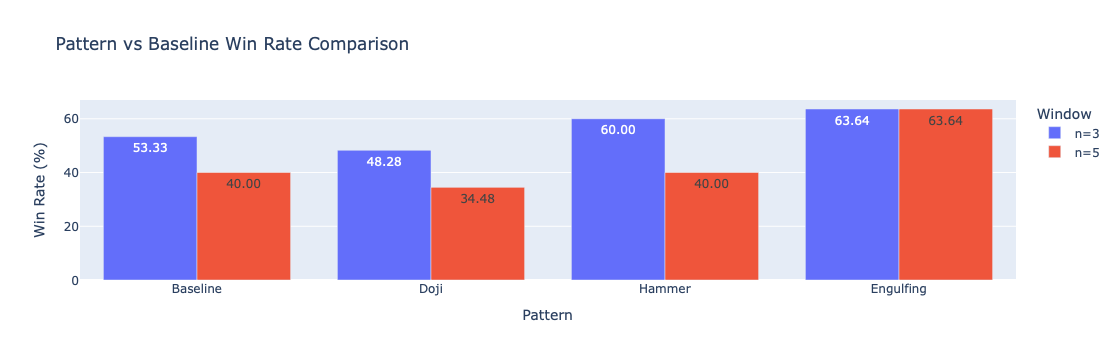

In [50]:
# Get win-rate dictionaries for both horizons
win_rates_3 = gather_all_win_rates(data_with_patterns, n=3)
win_rates_5 = gather_all_win_rates(data_with_patterns, n=5)

# Plot the grouped bar chart
plot_grouped_bar(win_rates_3, win_rates_5)

Answer in context to above question (100-300 words)
1. Interpret whether each pattern provides a statistically significant edge over the baseline.
Answer: It can be observed that Hammer(for n=3) and Engulfing patterns provide a significant edge over the baseline but Hammer(for n=5) and Doji pattern do not provide any edge over the baseline.

2. How does changing n affect the win-rates? No need to show your results. Answer qualitatively.
Answer: It can be observed from the plot that Win-rate decreases as n increases. The reason behind this is longer look-ahead windows introduce more market noise and uncertainty.

3. Which pattern shows the most consistent performance on different n? Why would that be?
Answer: Engulfing pattern shows the most consistent performance on different n because it reflects a decisive shift in market sentiment, often leading to sustained price moves, which remain effective across short and medium timeframes.

Problem Statement 3: Strategy X - Visual Interpretation and Implementation
Overview
The image below illustrates a technical analysis framework referred to as Strategy X. This
strategy is based on technical indicators and is visualised in the image, and it is open to multiple
interpretations .
”Different traders may extract different insights from the same visual patterns and signals”.


1. Chart Interpretation:
• Analyze the image to understand the underlying trading logic or intuition.
• Identify the main technical indicators visible.
• Explain what the marked zones, arrows, and annotations on the MFI represent in the
context of signal generation.

Answer: The main technical indicators used are - Heikin Ashi Candles, MFI(14) and Supertrend(10,3).
The marked zones are:
i>>Downtrend (Red Supertrend) : represents that prices are below supertrend.
ii>>Uptrend (green Supertrend) : represents that prices are above supertrend.
iii>>Sideways : represents uncertainty in the market.

Arrows:
Green upward arrow: represents buy signals
Red downward arrow: represents sell signals or caution

Annotaions on MFI:
Selling Pressure Increasing: MFI falling below 50.
Buying Pressure Increasing: MFI rising from below 20.
Buying Pressure Decreasing: MFI falling from above 80 or mid zone.

2. Entry and Exit Rules:
• Define conditions for entering and exiting both long and short positions based on
the chart analysis.
• Suggest any alternative rule variants if applicable, acknowledging the subjective
nature of technical strategies.

Answer: 
Long entry :
Heikin ashi close > supertrend
MFI crosses above 20 from below or shows a increasing slope

Long exit :
Heikin ashi close < supertrend
MFI shows a peak and starts sloping down from above 60-80

Short entry :
Heikin ashi close < supertrend
MFI falls below 80 from above or shows a declining slope

Short exit :
Heikin ashi close > supertrend
MFI rises above 40-50 after being about below 20

Alternative rule/variants :
MFI Divergence: we can use bullish/bearish divergence between price and MFI to anticipate reversals.

3. Strategy Implementation and Backtest: Backtest your strategy on this dataset and present the following:

Bactest results
Visual chart with entries and exits clearly marked

In [53]:
import yfinance as yf
import pandas as pd
import numpy as np

def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)
    data.columns.name = None 
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns] 
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True) 
    data['datetime'] = pd.to_datetime(data['datetime'])
    return data

df = download_flat_yf("CAMS.NS", start="2024-01-01", end="2025-05-04", interval="1d")
df.head()

,datetime,close,high,low,open,volume
0,2024-01-01,2601.022705,2629.011811,2595.915969,2611.334481,66066
1,2024-01-02,2621.842285,2646.688799,2603.035668,2607.405849,143141
2,2024-01-03,2604.558105,2637.653946,2602.004618,2622.824535,112428
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882


In [55]:
def heiken_ashi(df):
    df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha_open = [df['open'].iloc[0]]
    for i in range(1, len(df)):
        ha_open.append((ha_open[i-1] + df['HA_Close'].iloc[i-1]) / 2)
    df['HA_Open'] = ha_open
    df['HA_High'] = df[['high', 'HA_Open', 'HA_Close']].max(axis=1)
    df['HA_Low'] = df[['low', 'HA_Open', 'HA_Close']].min(axis=1)
    return df
df = heiken_ashi(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low
0,2024-01-01,2601.022705,2629.011811,2595.915969,2611.334481,66066,2609.321241,2611.334481,2629.011811,2595.915969
1,2024-01-02,2621.842285,2646.688799,2603.035668,2607.405849,143141,2619.743150,2610.327861,2646.688799,2603.035668
2,2024-01-03,2604.558105,2637.653946,2602.004618,2622.824535,112428,2616.760301,2615.035506,2637.653946,2602.004618
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.897903,2695.547197,2615.897903
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638176,2718.380493,2633.638176


In [57]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=10):
    data = df.copy()
    high = data['high']
    low = data['low']
    close = data['close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

In [59]:
def supertrend(df, atr_multiplier=3):
    # Calculate the Upper Band(UB) and the Lower Band(LB)
    # Formular: Supertrend =(High+Low)/2 + (Multiplier)∗(ATR)
    current_average_high_low = (df['high']+df['low'])/2
    df['atr'] = atr(df, 10)
    df.dropna(inplace=True)
    df['basicUpperband'] = current_average_high_low + (atr_multiplier * df['atr'])
    df['basicLowerband'] = current_average_high_low - (atr_multiplier * df['atr'])
    first_upperBand_value = df['basicUpperband'].iloc[0]
    first_lowerBand_value = df['basicLowerband'].iloc[0]
    upperBand = [first_upperBand_value]
    lowerBand = [first_lowerBand_value]

    for i in range(1, len(df)):
        if df['basicUpperband'].iloc[i] < upperBand[i-1] or df['close'].iloc[i-1] > upperBand[i-1]:
            upperBand.append(df['basicUpperband'].iloc[i])
        else:
            upperBand.append(upperBand[i-1])

        if df['basicLowerband'].iloc[i] > lowerBand[i-1] or df['close'].iloc[i-1] < lowerBand[i-1]:
            lowerBand.append(df['basicLowerband'].iloc[i])
        else:
            lowerBand.append(lowerBand[i-1])

    df['upperband'] = upperBand
    df['lowerband'] = lowerBand
    df.drop(['basicUpperband', 'basicLowerband',], axis=1, inplace=True)
    return df
df = supertrend(df,3)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband
0,2024-01-01,2601.022705,2629.011811,2595.915969,2611.334481,66066,2609.321241,2611.334481,2629.011811,2595.915969,33.095842,2711.751417,2513.176363
1,2024-01-02,2621.842285,2646.688799,2603.035668,2607.405849,143141,2619.743150,2610.327861,2646.688799,2603.035668,34.352867,2711.751417,2521.803632
2,2024-01-03,2604.558105,2637.653946,2602.004618,2622.824535,112428,2616.760301,2615.035506,2637.653946,2602.004618,34.482514,2711.751417,2521.803632
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.897903,2695.547197,2615.897903,40.133171,2711.751417,2538.933710
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638176,2718.380493,2633.638176,41.977923,2711.751417,2565.046839


In [61]:
def generate_supertrend_signals(df):
    # Intiate a signals list
    signals = [0]
    # Loop through the dataframe
    for i in range(1 , len(df)):
        if df['close'].iloc[i] > df['upperband'].iloc[i]:
            signals.append(1)
        elif df['close'].iloc[i] < df['lowerband'].iloc[i]:
            signals.append(-1)
        else:
            signals.append(signals[i-1])

    # Add the signals list as a new column in the dataframe
    df['supertrend'] = signals
    df['supretrend'] = df['supertrend'].shift(1) #Remove look ahead bias
    return df
generate_supertrend_signals(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend
0,2024-01-01,2601.022705,2629.011811,2595.915969,2611.334481,66066,2609.321241,2611.334481,2629.011811,2595.915969,33.095842,2711.751417,2513.176363,0,NaN
1,2024-01-02,2621.842285,2646.688799,2603.035668,2607.405849,143141,2619.743150,2610.327861,2646.688799,2603.035668,34.352867,2711.751417,2521.803632,0,0.0
2,2024-01-03,2604.558105,2637.653946,2602.004618,2622.824535,112428,2616.760301,2615.035506,2637.653946,2602.004618,34.482514,2711.751417,2521.803632,0,0.0
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.897903,2695.547197,2615.897903,40.133171,2711.751417,2538.933710,0,0.0
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638176,2718.380493,2633.638176,41.977923,2711.751417,2565.046839,0,0.0


In [63]:
def calculate_mfi(df, period=14):
    TP = (df["high"] + df["low"] + df["close"]) / 3
    MoneyFlow = TP * df["volume"]
    positive_flow = []
    negative_flow = []
    for i in range(1, len(TP)):
        if TP[i] > TP[i - 1]:
            positive_flow.append(MoneyFlow[i])
            negative_flow.append(0)
        elif TP[i] < TP[i - 1]:
            positive_flow.append(0)
            negative_flow.append(MoneyFlow[i])
        else:
            positive_flow.append(0)
            negative_flow.append(0)
    positive_mf = pd.Series(positive_flow).rolling(window=period).sum()
    negative_mf = pd.Series(negative_flow).rolling(window=period).sum()
    MFR = positive_mf / negative_mf
    MFI = 100 - (100 / (1 + MFR))
    # typical_price = (df['high'] + df['low'] + df['close']) / 3
    # raw_money_flow = typical_price * df['volume']
    
    # positive_flow = [0] * len(df)
    # negative_flow = [0] * len(df)
    
    # for i in range(1, len(df)):
    #     if typical_price.iloc[i] > typical_price.iloc[i-1]:
    #         positive_flow[i] = raw_money_flow.iloc[i]
    #     else:
    #         negative_flow[i] = raw_money_flow.iloc[i]
    
    # mfi = 100 - (100 / (1 + (pd.Series(positive_flow).rolling(period).sum() / 
    #                         pd.Series(negative_flow).rolling(period).sum())))
    df['MFI'] = MFI
    return df
df = calculate_mfi(df,14)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI
0,2024-01-01,2601.022705,2629.011811,2595.915969,2611.334481,66066,2609.321241,2611.334481,2629.011811,2595.915969,33.095842,2711.751417,2513.176363,0,NaN,NaN
1,2024-01-02,2621.842285,2646.688799,2603.035668,2607.405849,143141,2619.743150,2610.327861,2646.688799,2603.035668,34.352867,2711.751417,2521.803632,0,0.0,NaN
2,2024-01-03,2604.558105,2637.653946,2602.004618,2622.824535,112428,2616.760301,2615.035506,2637.653946,2602.004618,34.482514,2711.751417,2521.803632,0,0.0,NaN
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.897903,2695.547197,2615.897903,40.133171,2711.751417,2538.933710,0,0.0,NaN
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638176,2718.380493,2633.638176,41.977923,2711.751417,2565.046839,0,0.0,NaN


In [65]:
def backtest_strategy(data):
    data['Signal'] = 0
    data.loc[(data['supertrend'] == 1) & (data['MFI'] < 80), 'Signal'] = 1
    data.loc[(data['supertrend'] == -1) & (data['MFI'] > 20), 'Signal'] = -1
    
    # Calculate returns
    data['Return'] = data['close'].pct_change()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']
    
    # Metrics
    total_return = data['Strategy_Return'].sum() * 100
    win_rate = (data[data['Strategy_Return'] > 0].shape[0] / 
               data[data['Strategy_Return'] != 0].shape[0]) * 100
    
    print(f"Total Return: {total_return:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")
    return data
df = backtest_strategy(df)
df.head()

Total Return: -43.02%
Win Rate: 49.83%


,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return
0,2024-01-01,2601.022705,2629.011811,2595.915969,2611.334481,66066,2609.321241,2611.334481,2629.011811,2595.915969,33.095842,2711.751417,2513.176363,0,NaN,NaN,0,NaN,NaN
1,2024-01-02,2621.842285,2646.688799,2603.035668,2607.405849,143141,2619.743150,2610.327861,2646.688799,2603.035668,34.352867,2711.751417,2521.803632,0,0.0,NaN,0,0.008004,0.0
2,2024-01-03,2604.558105,2637.653946,2602.004618,2622.824535,112428,2616.760301,2615.035506,2637.653946,2602.004618,34.482514,2711.751417,2521.803632,0,0.0,NaN,0,-0.006592,-0.0
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.897903,2695.547197,2615.897903,40.133171,2711.751417,2538.933710,0,0.0,NaN,0,0.021210,0.0
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638176,2718.380493,2633.638176,41.977923,2711.751417,2565.046839,0,0.0,NaN,0,0.014695,0.0


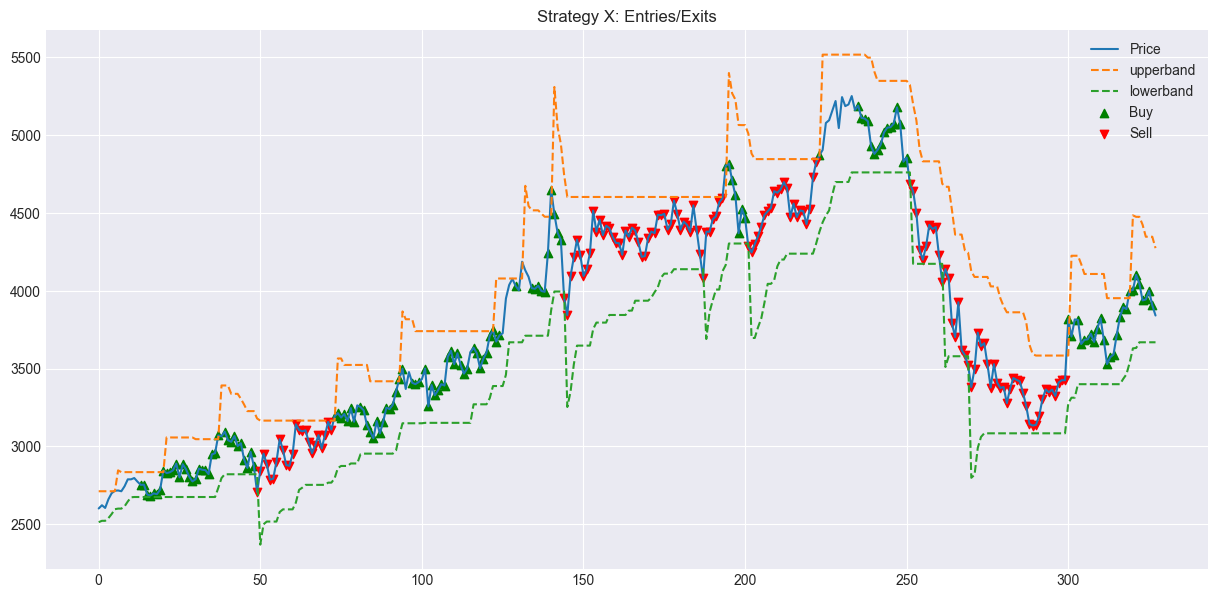

In [67]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Price')
plt.plot(df['upperband'], label='upperband', linestyle='--')
plt.plot(df['lowerband'], label='lowerband', linestyle='--')
plt.scatter(df[df['Signal'] == 1].index, 
            df[df['Signal'] == 1]['close'], 
            marker='^', color='g', label='Buy')
plt.scatter(df[df['Signal'] == -1].index, 
            df[df['Signal'] == -1]['close'], 
            marker='v', color='r', label='Sell')
plt.title('Strategy X: Entries/Exits')
plt.legend()
plt.show()

4. Incorporating a Complementary Indicator:
   Adding an indicator that brings volatility into the play

In [73]:
df['atr_ma'] = df['atr'].rolling(30).mean()
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,atr_ma
0,2024-01-01,2601.022705,2629.011811,2595.915969,2611.334481,66066,2609.321241,2611.334481,2629.011811,2595.915969,33.095842,2711.751417,2513.176363,0,NaN,NaN,0,NaN,NaN,NaN
1,2024-01-02,2621.842285,2646.688799,2603.035668,2607.405849,143141,2619.743150,2610.327861,2646.688799,2603.035668,34.352867,2711.751417,2521.803632,0,0.0,NaN,0,0.008004,0.0,NaN
2,2024-01-03,2604.558105,2637.653946,2602.004618,2622.824535,112428,2616.760301,2615.035506,2637.653946,2602.004618,34.482514,2711.751417,2521.803632,0,0.0,NaN,0,-0.006592,-0.0,NaN
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.897903,2695.547197,2615.897903,40.133171,2711.751417,2538.933710,0,0.0,NaN,0,0.021210,0.0,NaN
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638176,2718.380493,2633.638176,41.977923,2711.751417,2565.046839,0,0.0,NaN,0,0.014695,0.0,NaN


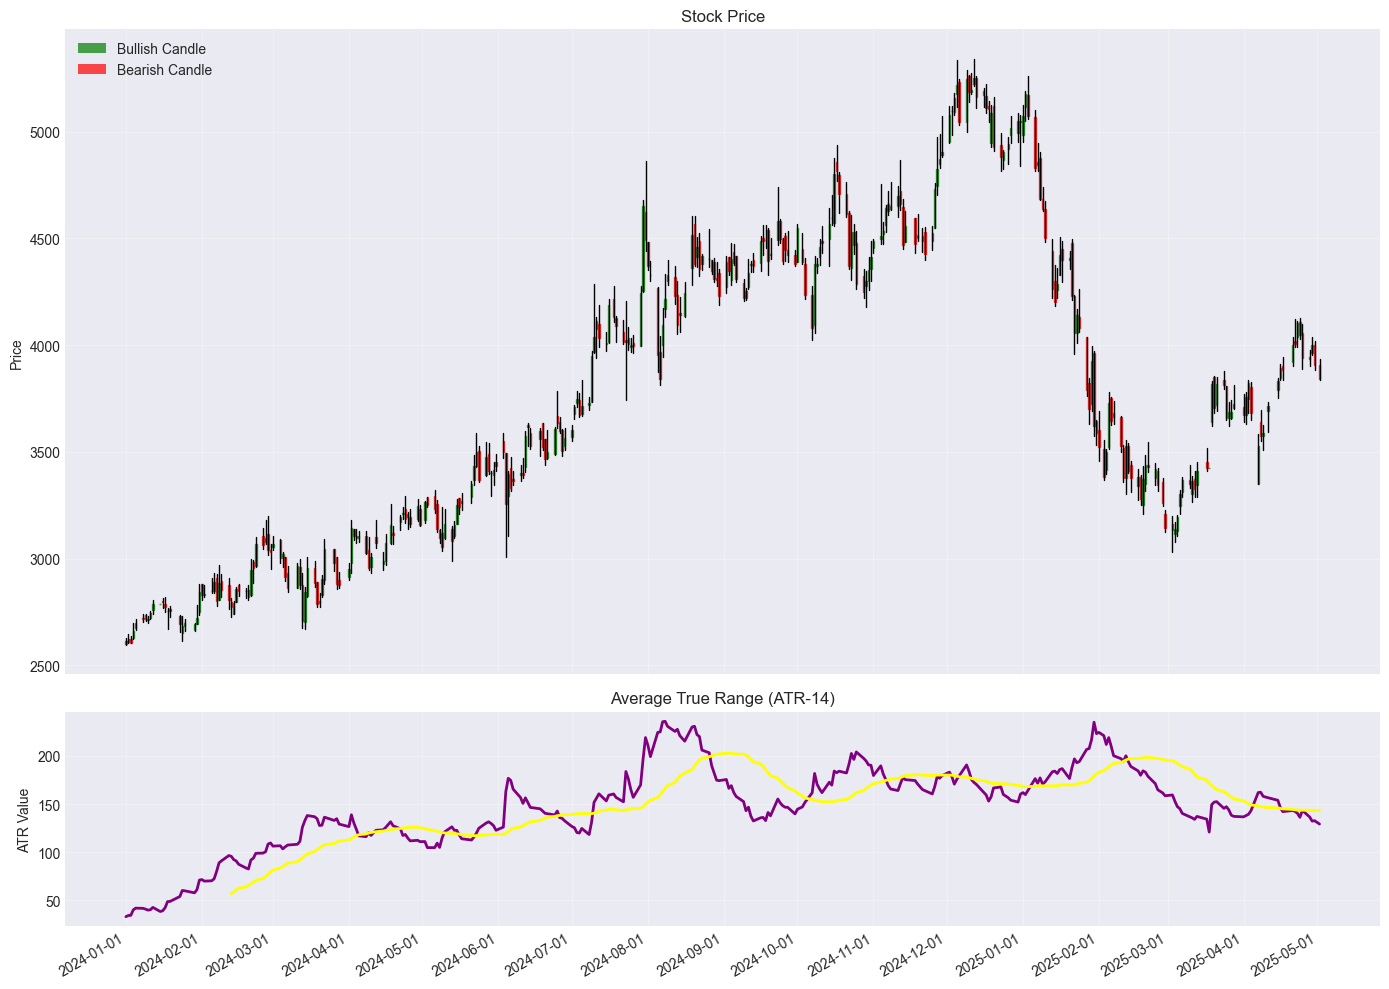

In [75]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
def plot_stock_with_atr(df, atr_period=14):
    """
    Plot stock price data with candlesticks, volatility zones, and ATR.
    
    Parameters:
    - df: DataFrame with OHLC data and volatility zones
    - atr_period: Period for ATR calculation
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Format date axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    
    # Plot candlestick chart
    for i, row in df.iterrows():
        # Determine candle color
        if row['close'] >= row['open']:
            color = 'green'
            body_bottom = row['open']
            body_height = row['close'] - row['open']
        else:
            color = 'red'
            body_bottom = row['close']
            body_height = row['open'] - row['close']
        
        # Plot candlestick body
        ax1.add_patch(Rectangle(
            (mdates.date2num(row['datetime'])-0.3, body_bottom),
            0.6, body_height, fill=True, color=color, alpha=0.7
        ))
        
        # Plot high/low wicks
        ax1.plot(
            [mdates.date2num(row['datetime']), mdates.date2num(row['datetime'])],
            [row['low'], row['high']],
            color='black', linewidth=1
        )
    # Plot ATR on the second subplot
    ax2.plot(df['datetime'], df['atr'], color='purple', linewidth=2)
    ax2.plot(df['datetime'], df['atr_ma'], color='yellow', linewidth=2)
    ax2.set_title(f'Average True Range (ATR-{atr_period})')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylabel('ATR Value')
    
    # Set titles and labels
    ax1.set_title('Stock Price')
    ax1.set_ylabel('Price')
    ax1.grid(True, alpha=0.3)
    
    # Add a legend for candlesticks
    green_patch = plt.Rectangle((0, 0), 1, 1, fc="green", alpha=0.7)
    red_patch = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.7)
    ax1.legend([green_patch, red_patch], ['Bullish Candle', 'Bearish Candle'], loc='upper left')
    
    # Format x-axis dates
    fig.autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

plot_stock_with_atr(df, atr_period=14)

In [77]:
def strategy_y(data):
    # Existing Strategy X signals
    data['Signal'] = 0
    data.loc[(data['supertrend'] == 1) & (data['MFI'] < 80), 'Signal'] = 1
    data.loc[(data['supertrend'] == -1) & (data['MFI'] > 20), 'Signal'] = -1

    # Add ATR filter (only trade when ATR > ATR_MA)
    data['Signal'] = np.where(data['atr'] > data['atr_ma'], data['Signal'], 0)

    # Calculate returns
    data['Return'] = data['close'].pct_change()
    data['Strategy_Return_Y'] = data['Signal'].shift(1) * data['Return']
    total_return = data['Strategy_Return_Y'].sum() * 100
    win_rate = (data[data['Strategy_Return_Y'] > 0].shape[0] / 
               data[data['Strategy_Return_Y'] != 0].shape[0]) * 100
    
    print(f"Total Return: {total_return:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")

    return data
df = strategy_y(df)
df.head()

Total Return: -31.44%
Win Rate: 45.58%


,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,atr_ma,Strategy_Return_Y
0,2024-01-01,2601.022705,2629.011811,2595.915969,2611.334481,66066,2609.321241,2611.334481,2629.011811,2595.915969,33.095842,2711.751417,2513.176363,0,NaN,NaN,0,NaN,NaN,NaN,NaN
1,2024-01-02,2621.842285,2646.688799,2603.035668,2607.405849,143141,2619.743150,2610.327861,2646.688799,2603.035668,34.352867,2711.751417,2521.803632,0,0.0,NaN,0,0.008004,0.0,NaN,0.0
2,2024-01-03,2604.558105,2637.653946,2602.004618,2622.824535,112428,2616.760301,2615.035506,2637.653946,2602.004618,34.482514,2711.751417,2521.803632,0,0.0,NaN,0,-0.006592,-0.0,NaN,-0.0
3,2024-01-04,2659.799805,2695.547197,2623.119251,2627.047546,268532,2651.378450,2615.897903,2695.547197,2615.897903,40.133171,2711.751417,2538.933710,0,0.0,NaN,0,0.021210,0.0,NaN,0.0
4,2024-01-05,2698.886230,2718.380493,2663.580723,2676.396835,354882,2689.311070,2633.638176,2718.380493,2633.638176,41.977923,2711.751417,2565.046839,0,0.0,NaN,0,0.014695,0.0,NaN,0.0


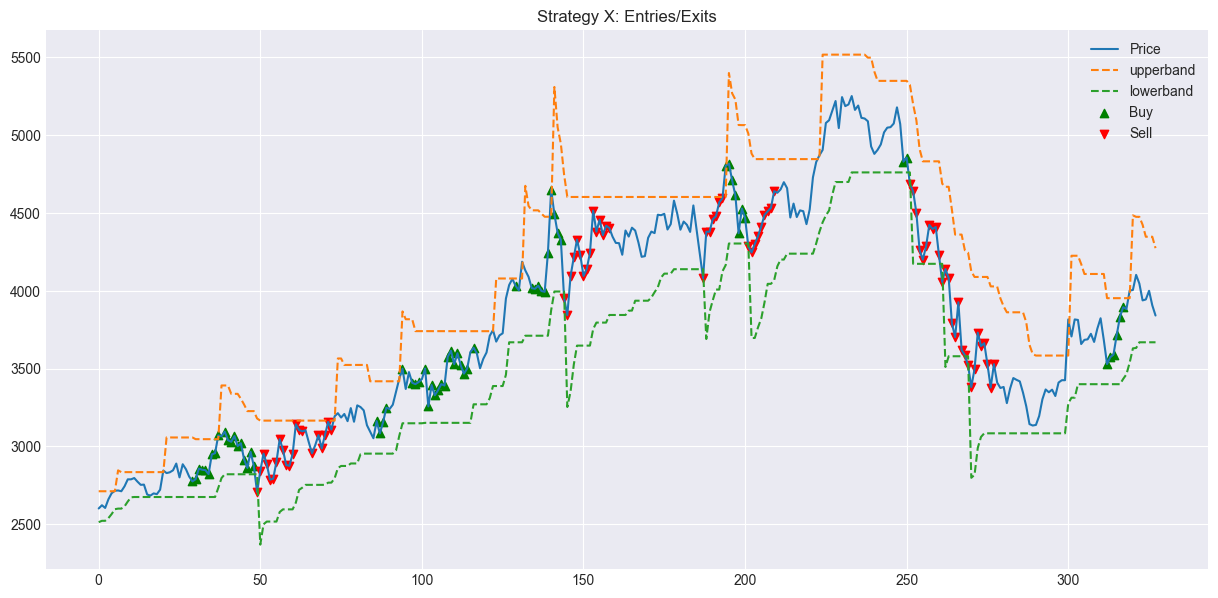

In [79]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Price')
plt.plot(df['upperband'], label='upperband', linestyle='--')
plt.plot(df['lowerband'], label='lowerband', linestyle='--')
plt.scatter(df[df['Signal'] == 1].index, 
            df[df['Signal'] == 1]['close'], 
            marker='^', color='g', label='Buy')
plt.scatter(df[df['Signal'] == -1].index, 
            df[df['Signal'] == -1]['close'], 
            marker='v', color='r', label='Sell')
plt.title('Strategy X: Entries/Exits')
plt.legend()
plt.show()

5. Strategy Enhancements:

Identify market regimes (e.g., sideways, choppy, low-volume) where the strategy may underperform or give false signals.
Propose modifications to adapt the strategy for these regimes, considering time-frame sensitivity, indicator tuning, or additional filters.

Answer: The strategy may underperform in sideways or choppy markets, where Supertrend frequently flips, causing whipsaws, and MFI gives unreliable signals due to inconsistent momentum. In low-volume phases, MFI loses significance as volume-based pressure becomes less meaningful.

Enhancements:

ATR Filter: Avoid trades when ATR is below a threshold, filtering out flat, low-volatility conditions.
EMA Trend Filter: Use a 200-period EMA to trade only in the direction of the broader trend (long above, short below).
These filters help reduce false signals and improve reliability across varying market regimes.